# Trabalho Prático 1 - Algoritmos II - Geometria computacional
Alunos: Gabriel Lemos - 2021032056, Davi Fraga - 2020420575

## Import de bibliotecas
Importe das bibliotas utilizadas no código

In [317]:
import numpy as np

import math

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

import sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import random

# biblioteca para facilitar leitura e tratamento dos dados de datasets que possam ser encontrados na UC Irvine Machine Learning Repository
!pip3 install -U ucimlrepo
from ucimlrepo import fetch_ucirepo


## Envoltória Convexa

Algoritmo de Graham para cálculo da envoltória convexa.  

In [318]:
# ENVOLTÓRIA CONVEXA:

def orientation(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0:
        return 0
    return 1 if val > 0 else 2  # Sentido horário ou anti-horário

def lowest_point(points):
    lowest = points[0]
    for point in points:
        if point[1] < lowest[1] or (point[1] == lowest[1] and point[0] < lowest[0]):
            lowest = point
    return lowest

# Função para ordenar pontos angularmente a partir do ponto mais baixo
def sort_angularly(points):
    lowest = lowest_point(points)
    return sorted(points, key=lambda point: (np.arctan2(point[1] - lowest[1], point[0] - lowest[0]), point))

def convex_hull(points):
    n = len(points)
    if n < 3:
        return None  # No mínimo 3 pontos

    sorted_points = sort_angularly(points)
    hull = [sorted_points[0], sorted_points[1]]

    for i in range(2, n):
        while len(hull) > 1 and orientation(hull[-2], hull[-1], sorted_points[i]) != 2:
            hull.pop()
        hull.append(sorted_points[i])

    return hull

## Interseção das envoltórias

Código para checar se ocorre uma interseção entre as envoltórias.

In [319]:
# INTERSEÇÃO ENTRE ENVOLTÓRIAS:

def on_segment(p, q, r):
    if (
        min(p[0], r[0]) <= q[0] <= max(p[0], r[0])
        and min(p[1], r[1]) <= q[1] <= max(p[1], r[1])
    ):
        return True
    return False

def do_intersect(p1, q1, p2, q2):
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False

def check_convex_hull_overlap(convex_hull1, convex_hull2):
    n1 = len(convex_hull1)
    n2 = len(convex_hull2)

    for i in range(n1):
        for j in range(n2):
            if do_intersect(
                convex_hull1[i], convex_hull1[(i + 1) % n1],
                convex_hull2[j], convex_hull2[(j + 1) % n2]
            ):
                return True  # There is intersection
    return False  # No intersection

## Cálculo das Retas do Gráfico


Cálculo da reta que representa a menor distância entre as duas envoltórias e da reta tangente à essa reta

In [320]:
# CALCULO DA MENOR DISTANCIA E RETA PERPENDICULAR:

def distance(p1, p2):
    p1 = ((p1[0]), (p1[1]))
    p2 = ((p2[0]), (p2[1]))
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def closest_points(set1, set2):
    min_dist = float('inf')
    points = None

    for p1 in set1:
        for p2 in set2:
            dist = distance(p1, p2)
            if dist < min_dist:
                min_dist = dist
                points = (p1, p2)

    return points, min_dist

def mid_point_line(p1, p2):
    return ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)

def perpendicular_line_mid_point(p1, p2):
    mid_point = mid_point_line(p1, p2)
    slope = (p2[1] - p1[1]) / (p2[0] - p1[0])

    # inclinação da reta perpendicular
    perpendicular_slope = -1 / slope

    # calcular coeficiente b na reta perpendicular
    b_perpendicular = mid_point[1] - perpendicular_slope * mid_point[0]

    # retorna a equação na forma y = ax + b
    return perpendicular_slope, b_perpendicular

## Plotar o gráfico

In [321]:
def Plot_Convex_Hull(set1, set2):
    set1 = np.array(set1)
    set2 = np.array(set2)
    closest_pts, min_distance = closest_points(set1, set2)

    hull_set1 = convex_hull(set1)
    hull_set2 = convex_hull(set2)

    # Calcular a reta tangente
    tangent_slope, tangent_intercept = perpendicular_line_mid_point(closest_pts[0], closest_pts[1])

    # Coordenadas dos pontos de interseção da reta tangente com as envoltórias
    intersection_point_set1 = np.array([tangent_slope * point[0] + tangent_intercept for point in hull_set1])
    intersection_point_set2 = np.array([(point[1] - tangent_intercept) / tangent_slope for point in hull_set2])

    # Ponto de interseção real
    intersection_point = np.array(tangent_intercept - intersection_point_set1[0] / (tangent_slope - 1/tangent_slope),
                                tangent_slope * (tangent_intercept - intersection_point_set2[0]) + intersection_point_set2[0])


    # Configurar o gráfico
    plt.figure(figsize=(10, 6))

    # Cores para cada conjunto de dados
    colors = ['red', 'blue']

    for idx, current_set in enumerate([set1, set2]):
        # Plotar os pontos
        plt.scatter(current_set[:, 0], current_set[:, 1], color=colors[idx], label=f'Conjunto {idx + 1}')

        # Plotar a envoltória convexa
        current_hull = convex_hull(current_set)
        current_hull.append(current_hull[0])  # Adicionar o primeiro ponto para fechar o polígono
        current_hull = np.array(current_hull)
        plt.plot(current_hull[:, 0], current_hull[:, 1], color=colors[idx], linestyle='-', label=f'Envoltória Convexa {idx + 1}')

    # Plotar a tangente
    x_vals = np.linspace(min(set1[:, 0].min(), set2[:, 0].min()) - 0.1, max(set1[:, 0].max(), set2[:, 0].max()) + 0.1, 100)
    y_vals = tangent_slope * x_vals + tangent_intercept
    plt.plot(x_vals, y_vals, color='green', label='Tangente à Reta de Menor Distância', linestyle='--')

    # Adicionar a reta de menor distância
    plt.plot([closest_pts[0][0], closest_pts[1][0]], [closest_pts[0][1], closest_pts[1][1]], color='purple', linestyle='--', label='Reta de Menor Distância')

    # Configurar o gráfico
    plt.title('Envoltórias Convexas, Menor Distância e Tangente')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"A equação da reta perpendicular é: y = {-1/tangent_slope:.4f}x + {tangent_intercept:.4f}")


## Tratamento dos dados

### Aplicação do método de bidimensionalização no dataset.

O método aplicado para realização da bidimensionalização do dataset, foi o método PCA (Principal Component Analysis), onde ele reduz a quantidade de informações importantes.

In [322]:
# APLICACAO DO MÉTODO PCA (bidimensionalização dos dados)

def apply_pca(df, target_name):

    targets = df[target_name]
    df_numeric = df.select_dtypes(include=['number'])
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_numeric)
    df_pca = pd.DataFrame(df_pca, columns=['Componente 1', 'Componente 2'])

    explained_variance_ratio = pca.explained_variance_ratio_
    total_explained_variance = explained_variance_ratio.sum()

    print(f'Variação total explicada pelos dois primeiros componentes: {total_explained_variance * 100:.2f}%')

    df_pca[target_name] = targets.reset_index(drop=True)
    df_pca = df_pca.rename(columns={target_name : 'class'})

    return df_pca

def plot_pca(df):
    sns.scatterplot(data=df, x='Componente 1', y='Componente 2', hue='class')

# uso da funcao apply PCA para datasets que possam ser encontrados na UCI (UC Irvine Machine Learning Repository)
def pca_uci(id_num, target_name):
    data = fetch_ucirepo(id=id_num)
    A = data.data.features
    y = data.data.targets
    feat = pd.DataFrame(A)
    tar = pd.DataFrame(y)
    df = pd.concat([feat, tar], axis=1)
    df = df.dropna()

    df_pca = apply_pca(df, target_name)
    return df_pca

### Divisão dos dados

Separação dos dados em conjuntos de treino e de teste, seguindo uma proporção de 70% sendo treino e os 30% restantes sendo de teste

In [323]:
# DIVISÃO DO DATASET (treino e teste)

def split_data(df):
    # Divisão do DataFrame em conjuntos de treinamento e teste (proporção 3:7)
    data_train, data_test = train_test_split(df, test_size=0.3, random_state=4)
    return data_train, data_test

## Criação do modelo

Criação do modelo com base no dataset escolhido. O modelo será criado apenas se as envoltórias não se cruzarem, ou seja, caso ambos conjuntos sejam linearmente separáveis

In [324]:
#  EXECUTA O CÓDIGO E RETORNA OS PONTO DAS CLASSES
#  TAMBÉM VERIFICA A INTERSEÇÃO

def New_Model(df):
    classes = df['class'].unique()
    df_class1 = df.loc[df['class'] == classes[0]]
    df_class2 = df.loc[df['class'] == classes[1]]

    set1 = list(zip(df_class1['Componente 1'], df_class1['Componente 2']))
    set2 = list(zip(df_class2['Componente 1'], df_class2['Componente 2']))
    convex_set1 = convex_hull(set1)
    convex_set2 = convex_hull(set2)

    inters = check_convex_hull_overlap(convex_set1, convex_set2)
    if(inters):
        # se as envoltórias se cruzarem, o programa nao continua a execução!
        raise Exception('Envoltórias se cruzam, não é possível criar o modelo!')
    else:
      print('Envoltórias não se cruzam!')
    return convex_set1, convex_set2, classes

## Classificador

Implementação de um classificador que recebe os 30% do dataset que foram selecionados para o teste e retorna uma lista de pontos classificados de acordo com o conjunto que for classificado.


O método de classificação utilizado foi um dos mais simples, tomando apenas como base a menor distancia entre um determinado conjunto. Ou seja, de acordo com a proxidade com os pontos ao redor, ele será inserido nesse conjunto (espécie de KNN (K-Nearest Neighbors)). É possível acompanhar a classificação dos pontos nos conjuntos na parte do código que está comentada:

```
# Exibir os pontos classificados e suas classes
#for point, classification in classified_points:
    #print(f"Ponto {point} inserido no {classification}")
```




In [325]:
# ALGORITMO PARA REALIZAR A CLASSIFICAÇÃO DOS PONTOS

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# retorna uma lista com os pontos e a classe a qual ele pertence
def classify_and_insert_points(points, set1, set2, classes):
    points = points.iloc[:, :2]  # Selecione as duas primeiras colunas do dataset (a terceira será a classe)

    # Converta as duas primeiras colunas em uma lista de pontos ordenados
    points = [tuple(row) for row in points.values]
    classified_points = []

    set1 = np.array(set1)
    set2 = np.array(set2)

    for new_point in points:
        # Encontre o ponto mais próximo em cada conjunto
        nearest_point_set1 = set1[np.argmin([euclidean_distance(new_point, point) for point in set1])]
        nearest_point_set2 = set2[np.argmin([euclidean_distance(new_point, point) for point in set2])]

        # Calcule as distâncias dos pontos mais próximos
        distance_set1 = euclidean_distance(new_point, nearest_point_set1)
        distance_set2 = euclidean_distance(new_point, nearest_point_set2)

        # Insira o ponto no conjunto mais próximo
        if distance_set1 < distance_set2:
            set1 = np.vstack([set1, new_point])
            classified_points.append((new_point, classes[0]))
        else:
            set2 = np.vstack([set2, new_point])
            classified_points.append((new_point, classes[1]))

    return classified_points

# Exibir os pontos classificados e suas classes
#for point, classification in classified_points:
    #print(f"Ponto {point} inserido no {classification}")



## Métricas

Calculo das métricas desejadas utilizando a biblioteca sklearn

### Função auxiliar para realizar o cálculo das métricas

A função recebe uma lista de pontos classificados e tranforma-os em um novo dataset

In [326]:
# RECEBE UMA LISTA DE PONTOS E RETORNA UM DATASET

def New_Dataset(pontos):
  column1 = []
  column2 = []
  column_classes = []
  # Itere sobre a lista de pontos para extrair as informações desejadas.
  for ponto in pontos:
      column1.append(ponto[0][0])  # Coordenada X do ponto
      column2.append(ponto[0][1])  # Coordenada Y do ponto
      column_classes.append(ponto[1])  # Classe do ponto


  new_Dataset = pd.DataFrame({'Componente 1': column1, 'Componente 2': column2, 'class': column_classes})
  return new_Dataset

### Cálculo das métricas

A função, por meio da biblioteca sklearn, recebe os 2 datasets (original e o predito), juntamente com suas possíveis classes (classes), e, realiza a comparação de "como deveria ser" para o "como realmente foi".

Após isso, utilizando as funções da biblioteca, tem como resultado a precisão, revocação e f1_score das amostras obtidas.

In [327]:
# FUNÇÃO PARA REALIZAR O CÁLCULO DAS MÉTRICAS

def metrics_dataset(original, predito, classes):
    # Certifique-se de que os dois DataFrames tenham a mesma estrutura de colunas
    if set(original.columns) != set(predito.columns):
        raise ValueError("Os DataFrames de entrada têm estruturas de coluna diferentes.")

    # Extrair as classes reais do DataFrame original
    classes_reais = original['class']

    # Extrair as classes preditas do DataFrame predito
    classes_preditas = predito['class']

    # Calcular a precisão (accuracy)
    acuracia = accuracy_score(classes_reais, classes_preditas)

    # Calcular a precisão, revocação e escore F1 para cada classe
    precisao = precision_score(classes_reais, classes_preditas, average=None, labels=classes)
    revocacao = recall_score(classes_reais, classes_preditas, average=None, labels=classes)
    f1 = f1_score(classes_reais, classes_preditas, average=None, labels=classes)

    # Calcular a matriz de confusão
    matriz_confusao = confusion_matrix(classes_reais, classes_preditas, labels=classes)

    # Gerar um relatório de classificação
    relatorio_classificacao = classification_report(classes_reais, classes_preditas, labels=classes)


    # Exibir as métricas
    print("Acurácia:", acuracia)
    print("Precisão:", precisao)
    print("Revocação:", revocacao)
    print("Escore F1:", f1)
    print("Matriz de Confusão:")
    print(matriz_confusao)
    print("Relatório de Classificação:")
    print(relatorio_classificacao)


## Datasets

### Dataset Iris
Importado da biblioteca Seaborn

Variação total explicada pelos dois primeiros componentes: 97.98%
Envoltórias não se cruzam!


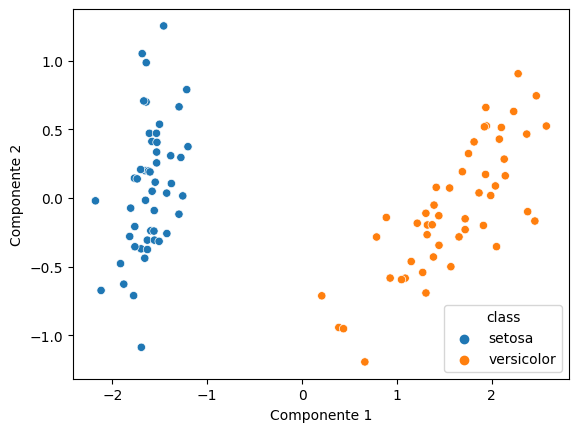

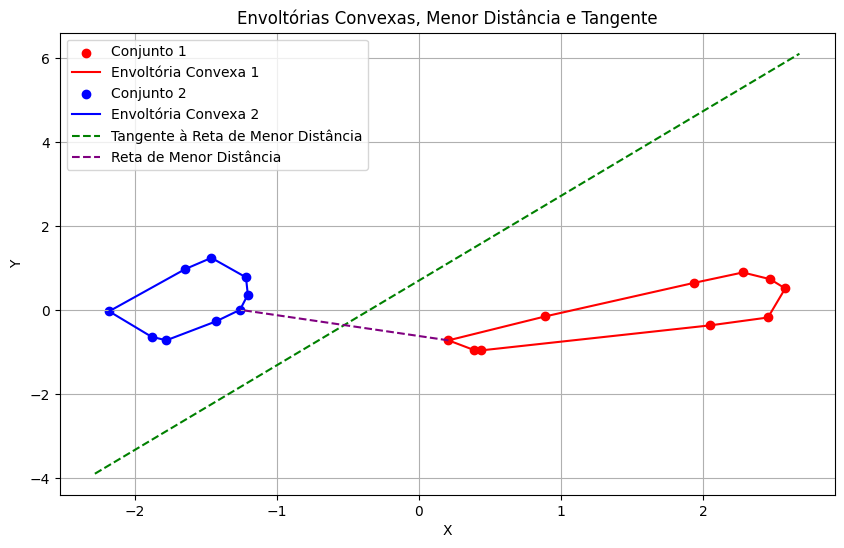

A equação da reta perpendicular é: y = -0.4958x + 0.7114
Acurácia: 1.0
Precisão: [1. 1.]
Revocação: [1. 1.]
Escore F1: [1. 1.]
Matriz de Confusão:
[[13  0]
 [ 0 17]]
Relatório de Classificação:
              precision    recall  f1-score   support

  versicolor       1.00      1.00      1.00        13
      setosa       1.00      1.00      1.00        17

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [328]:
# Importa dataset
iris = sns.load_dataset('iris')

# Tratamento dos dados
iris = iris[iris['species'] != 'virginica']
iris_pca = apply_pca(iris, "species")
plot_pca(iris_pca)

# Separação do conjunto de treinamento e teste
iris_treinamento, iris_teste = split_data(iris_pca)

# Classes possíveis no dataset
classes = ['setosa', 'versicolor']

pontos1, pontos2, classes = New_Model(iris_treinamento)
Plot_Convex_Hull(pontos1, pontos2)

# Classificacao dos novos pontos e criação de um novo dataset com as informações obtidas
points = classify_and_insert_points(iris_teste, pontos1, pontos2, classes)
novo_dataset = New_Dataset(points)

# Cálculo das métricas
metrics = metrics_dataset(iris_teste, novo_dataset, classes)

### Dataset Heart-Disease
https://archive.ics.uci.edu/dataset/45/heart+disease

#### Classificação por sexo (male ou female)

Variação total explicada pelos dois primeiros componentes: 89.57%


Exception: ignored

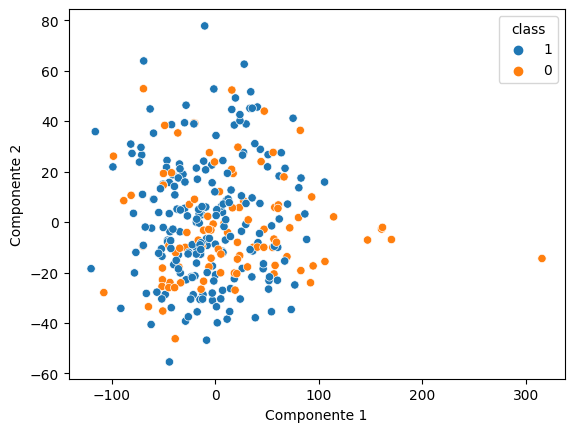

In [329]:
# Importa dataset
heart_pca = pca_uci(45, 'sex')

# Tratamento dos dados
heart_pca['class'] = heart_pca['class'].astype(str)
heart_pca = heart_pca[(heart_pca['class'] == '0') |(heart_pca['class'] == '1')]
plot_pca(heart_pca)

# Separação do conjunto de treinamento e teste
heart_treinamento, heart_teste = split_data(heart_pca)

# Classes possíveis no datasets
classes = ['0' , '1']

pontos1, pontos2, classes = New_Model(heart_treinamento)
Plot_Convex_Hull(pontos1, pontos2)

# Classificacao dos novos pontos e criação de um novo dataset com as informações obtidas
points = classify_and_insert_points(heart_teste, pontos1, pontos2, classes)
novo_dataset = New_Dataset(points)

# Cálculo das métricas
metricas = metrics_dataset(heart_teste, novo_dataset, classes)


#### Clasificação por FBS (fast blood sugar) > 120 mg/dl

Variação total explicada pelos dois primeiros componentes: 89.57%


Exception: ignored

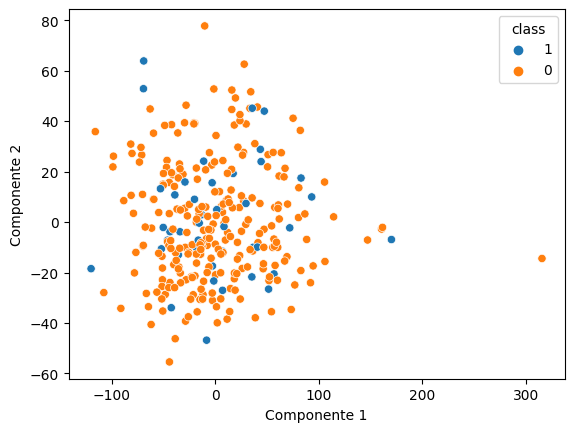

In [330]:
# Importa dataset
heart_pca = pca_uci(45, 'fbs')

# Tratamento dos dados
heart_pca['class'] = heart_pca['class'].astype(str)
heart_pca = heart_pca[(heart_pca['class'] == '0') |(heart_pca['class'] == '1')]
plot_pca(heart_pca)

# Separação do conjunto de treinamento e teste
heart_treinamento, heart_teste = split_data(heart_pca)

# Classes possíveis no datasets
classes = ['0' , '1']

pontos1, pontos2, classes = New_Model(heart_treinamento)
Plot_Convex_Hull(pontos1, pontos2)

# Classificacao dos novos pontos e criação de um novo dataset com as informações obtidas
points = classify_and_insert_points(heart_teste, pontos1, pontos2, classes)
novo_dataset = New_Dataset(points)

# Cálculo das métricas
metricas = metrics_dataset(heart_teste, novo_dataset, classes)


### Dataset Rice
https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik

Variação total explicada pelos dois primeiros componentes: 100.00%


Exception: ignored

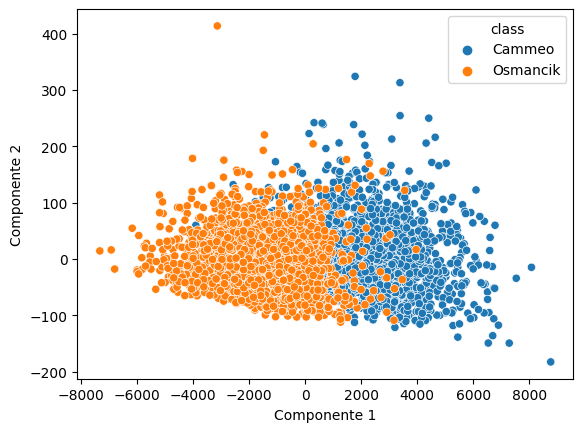

In [331]:
# Importa dataset
rice_pca = pca_uci(545, 'Class')

# Tratamento dos dados
rice_pca['class'] = rice_pca['class'].astype(str)
rice_pca = rice_pca[(rice_pca['class'] == 'Cammeo') |(rice_pca['class'] == 'Osmancik')]
plot_pca(rice_pca)

# Separação do conjunto de treinamento e teste
rice_treinamento, rice_teste = split_data(rice_pca)

# Classes possíveis no datasets
classes = ['Cammeo', 'Osmancik']

pontos1, pontos2, classes = New_Model(rice_treinamento)
Plot_Convex_Hull(pontos1, pontos2)

# Classificacao dos novos pontos e criação de um novo dataset com as informações obtidas
points = classify_and_insert_points(rice_teste, pontos1, pontos2, classes)
novo_dataset = New_Dataset(points)

# Cálculo das métricas e plot do grafico com o conjunto de treino
metricas = metrics_dataset(rice_teste, novo_dataset, classes)

### Dataset Breast Cancer
Importado da biblioteca Sklearn

Variação total explicada pelos dois primeiros componentes: 99.82%


Exception: ignored

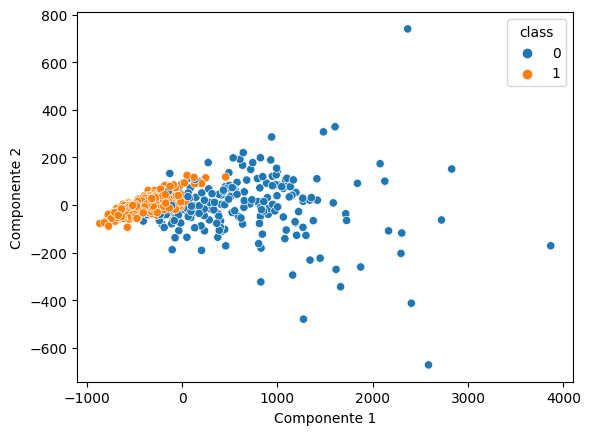

In [332]:
# Importa dataset
breast_cancer_data = sklearn.datasets.load_breast_cancer()

# Tratamento dos dados
breast_cancer = pd.DataFrame(breast_cancer_data.data, columns=breast_cancer_data.feature_names)
breast_cancer['target'] = breast_cancer_data.target
breast_pca = apply_pca(breast_cancer, 'target')
plot_pca(breast_pca)

# Separação do conjunto de treinamento e teste
breast_treinamento, breast_teste = split_data(breast_pca)

# Classes possíveis no datasets
classes = ['0', '1']

pontos1, pontos2, classes = New_Model(breast_treinamento)
Plot_Convex_Hull(pontos1, pontos2)

# Classificacao dos novos pontos e criação de um novo dataset com as informações obtidas
points = classify_and_insert_points(breast_teste, pontos1, pontos2, classes)
novo_dataset = New_Dataset(points)

# Cálculo das métricas
metricas = metrics_dataset(breast_teste, novo_dataset, classes)

### Dataset Vinho
Importado da biblioteca Sklearn

Variação total explicada pelos dois primeiros componentes: 99.98%


Exception: ignored

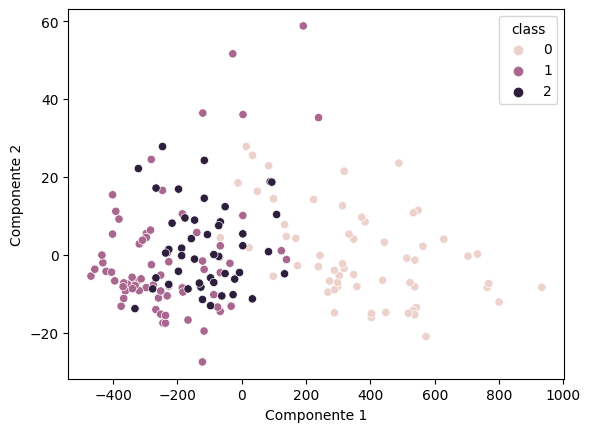

In [333]:
# Importa dataset
vinho_data = sklearn.datasets.load_wine()

# Tratamento dos dados
vinho = pd.DataFrame(vinho_data.data, columns=vinho_data.feature_names)
vinho['target'] = vinho_data.target
vinho_pca = apply_pca(vinho, 'target')
plot_pca(vinho_pca)

# Separação do conjunto de treinamento e teste
vinho_treinamento, vinho_teste = split_data(vinho_pca)

pontos1, pontos2, classes = New_Model(vinho_treinamento)
Plot_Convex_Hull(pontos1, pontos2)

# Classes possíveis no datasets
classes = ['class_0' , 'class_1' , 'class_2']

# Classificacao dos novos pontos e criação de um novo dataset com as informações obtidas
points = classify_and_insert_points(vinho_teste, pontos1, pontos2, classes)
novo_dataset = New_Dataset(points)

# Cálculo das métricas
metricas = metrics_dataset(vinho_teste, novo_dataset, classes)

### Dataset Penguins
Importado da biblioteca Seaborn

Variação total explicada pelos dois primeiros componentes: 100.00%
Envoltórias não se cruzam!


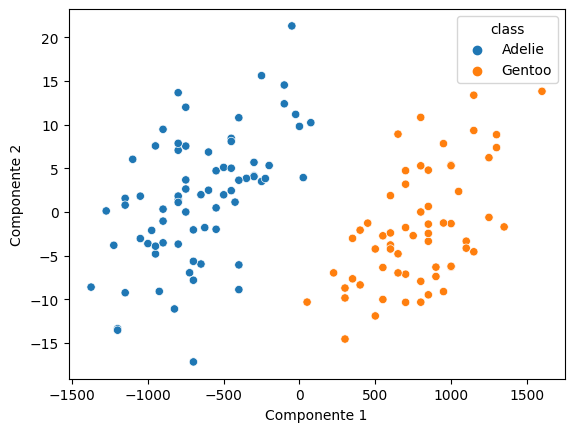

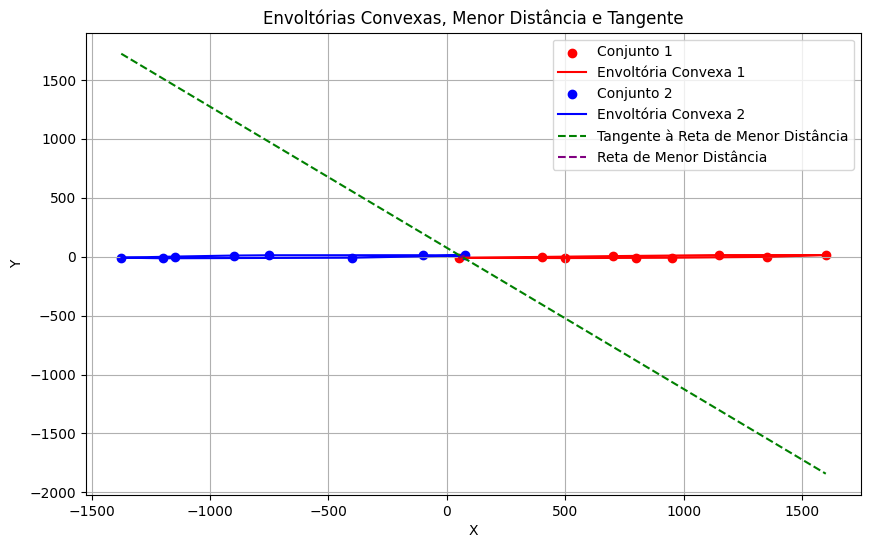

A equação da reta perpendicular é: y = 0.8348x + 75.2802
Acurácia: 0.975609756097561
Precisão: [0.9375 1.    ]
Revocação: [1.         0.96153846]
Escore F1: [0.96774194 0.98039216]
Matriz de Confusão:
[[15  0]
 [ 1 25]]
Relatório de Classificação:
              precision    recall  f1-score   support

      Gentoo       0.94      1.00      0.97        15
      Adelie       1.00      0.96      0.98        26

    accuracy                           0.98        41
   macro avg       0.97      0.98      0.97        41
weighted avg       0.98      0.98      0.98        41



In [334]:
# Importa dataset
penguins = sns.load_dataset('penguins')

# Tratamento dos dados
penguins = penguins.dropna()
penguins = penguins[penguins['species'] != 'Chinstrap']
penguins = penguins[penguins['sex'] != 'Female']
penguins_pca = apply_pca(penguins, 'species')
plot_pca(penguins_pca)

# Separação do conjunto de treinamento e teste
penguins_treinamento, penguins_teste = split_data(penguins_pca)

pontos1, pontos2, classes = New_Model(penguins_treinamento)
Plot_Convex_Hull(pontos1, pontos2)

# Classes possíveis no datasets
classes = ['Gentoo' , 'Adelie']

# Classificacao dos novos pontos e criação de um novo dataset com as informações obtidas
points = classify_and_insert_points(penguins_teste, pontos1, pontos2, classes)
novo_dataset = New_Dataset(points)

# Cálculo das métricas
metricas = metrics_dataset(penguins_teste, novo_dataset, classes)

### Dataset Automobile
https://archive.ics.uci.edu/dataset/10/automobile

#### Classificação por combustível

Variação total explicada pelos dois primeiros componentes: 99.87%


Exception: ignored

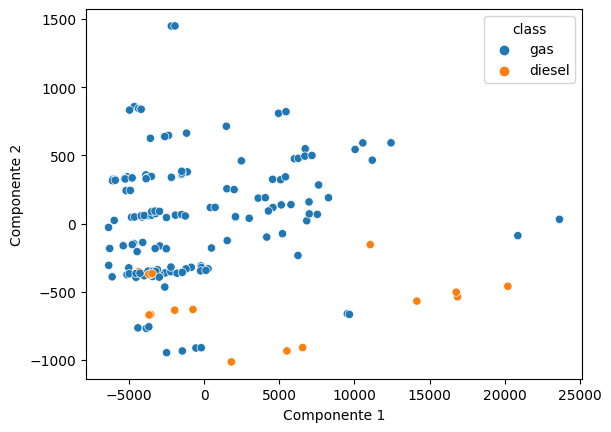

In [335]:
# Impota dataset
automobile_pca = pca_uci(10, 'fuel-type')

# Tratamento dos dados
automobile_pca['class'] = automobile_pca['class'].astype(str)
automobile_pca = automobile_pca[(automobile_pca['class'] == 'diesel') |(automobile_pca['class'] == 'gas')]
plot_pca(automobile_pca)

# Separação do conjunto de treinamento e teste
automobile_treinamento, automobile_teste = split_data(automobile_pca)


pontos1, pontos2, classes = New_Model(automobile_treinamento)
Plot_Convex_Hull(pontos1, pontos2)

# Classes possíveis no datasets
classes = ['gas' , 'diesel']

# Classificacao dos novos pontos e criação de um novo dataset com as informações obtidas
points = classify_and_insert_points(automobile_teste, pontos1, pontos2, classes)
novo_dataset = New_Dataset(points)

# Cálculo das métricas
metricas = metrics_dataset(automobile_teste, novo_dataset, classes)

#### Classificação por "aspiration" (turbo ou não)

Variação total explicada pelos dois primeiros componentes: 99.87%


Exception: ignored

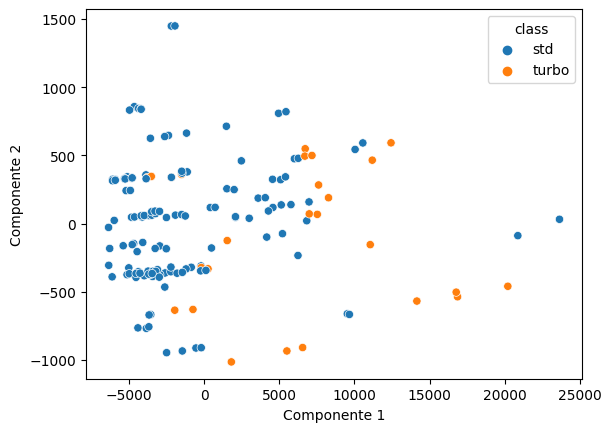

In [337]:
# Impota dataset
automobile_pca = pca_uci(10, 'aspiration')

# Tratamento dos dados
automobile_pca['class'] = automobile_pca['class'].astype(str)
automobile_pca = automobile_pca[(automobile_pca['class'] == 'std') |(automobile_pca['class'] == 'turbo')]
plot_pca(automobile_pca)

# Separação do conjunto de treinamento e teste
automobile_treinamento, automobile_teste = split_data(automobile_pca)

pontos1, pontos2, classes = New_Model(automobile_treinamento)
Plot_Convex_Hull(pontos1, pontos2)

# Classes possíveis no datasets
classes = ['std' , 'turbo']

# Classificacao dos novos pontos e criação de um novo dataset com as informações obtidas
points = classify_and_insert_points(automobile_teste, pontos1, pontos2, classes)
novo_dataset = New_Dataset(points)

# Cálculo das métricas
metricas = metrics_dataset(automobile_teste, novo_dataset, classes)

### Dataset Glass
https://archive.ics.uci.edu/dataset/42/glass+identification

Variação total explicada pelos dois primeiros componentes: 81.08%
Envoltórias não se cruzam!


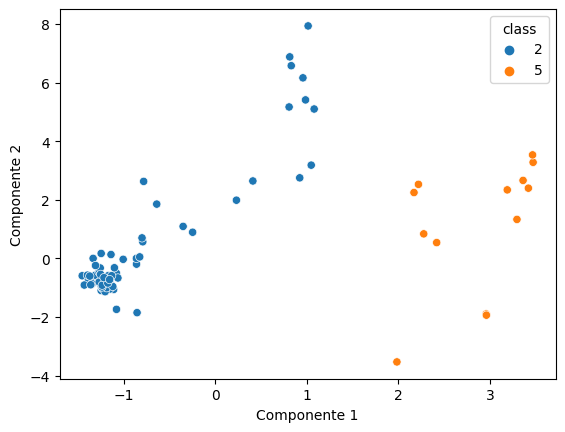

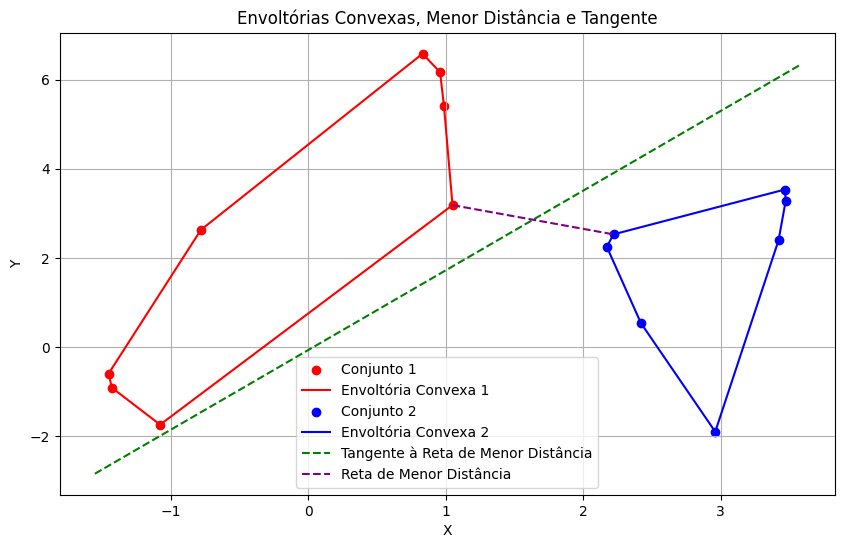

A equação da reta perpendicular é: y = -0.5598x + -0.0617
Acurácia: 1.0
Precisão: [1. 1.]
Revocação: [1. 1.]
Escore F1: [1. 1.]
Matriz de Confusão:
[[24  0]
 [ 0  3]]
Relatório de Classificação:
              precision    recall  f1-score   support

           2       1.00      1.00      1.00        24
           5       1.00      1.00      1.00         3

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



In [338]:
# Importa dataset
glass_pca = pca_uci(42, 'Type_of_glass')

# Tratamento dos dados
glass_pca['class'] = glass_pca['class'].astype(str)
glass_pca = glass_pca[(glass_pca['class'] == '5') | (glass_pca['class'] == '2')]
plot_pca(glass_pca)

# Separação do conjunto de treinamento e teste
glass_treinamento, glass_teste = split_data(glass_pca)

pontos1, pontos2, classes = New_Model(glass_treinamento)
Plot_Convex_Hull(pontos1, pontos2)

# Classes possíveis no datasets
classes = ['2' , '5']

# Classificacao dos novos pontos e criação de um novo dataset com as informações obtidas
points = classify_and_insert_points(glass_teste, pontos1, pontos2, classes)
novo_dataset = New_Dataset(points)

# Cálculo das métricas
metricas = metrics_dataset(glass_teste, novo_dataset, classes)

### Dataset Letter
https://archive.ics.uci.edu/dataset/59/letter+recognition


Variação total explicada pelos dois primeiros componentes: 43.74%


Exception: ignored

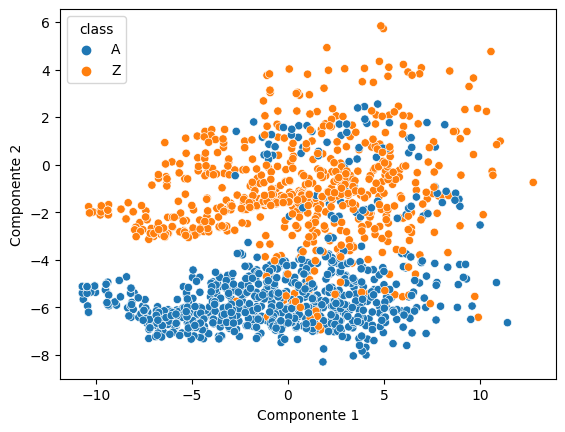

In [339]:
# Importa dataset
letter_pca = pca_uci(59, 'lettr')

# Tratamento dos dados
letter_pca['class'] = letter_pca['class'].astype(str)
letter_pca = letter_pca[(letter_pca['class'] == 'A') | (letter_pca['class'] == 'Z')]
plot_pca(letter_pca)

# Separação do conjunto de treinamento e teste
letter_treinamento, letter_teste = split_data(letter_pca)

pontos1, pontos2, classes = New_Model(letter_treinamento)
Plot_Convex_Hull(pontos1, pontos2)

# Classes possíveis no datasets
classes = ['A' , 'Z']

# Classificacao dos novos pontos e criação de um novo dataset com as informações obtidas
points = classify_and_insert_points(letter_teste, pontos1, pontos2, classes)
novo_dataset = New_Dataset(points)

# Cálculo das métricas
metricas = metrics_dataset(letter_teste, novo_dataset, classes)

### Dataset Income
https://archive.ics.uci.edu/dataset/20/census+income

Variação total explicada pelos dois primeiros componentes: 100.00%


Exception: ignored

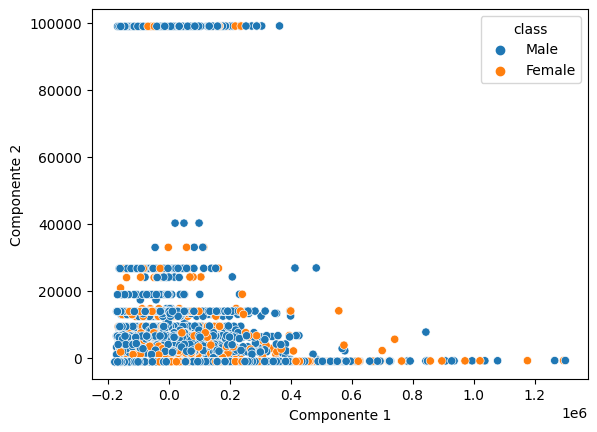

In [340]:
# Importa dataset
income_pca = pca_uci(2, 'sex')

# Tratamento dos dados
income_pca['class'] = income_pca['class'].astype(str)
income_pca = income_pca[(income_pca['class'] == 'Female') |(income_pca['class'] == 'Male')]
plot_pca(income_pca)

# Separação do conjunto de treinamento e teste
income_treinamento, income_teste = split_data(income_pca)

# Classes possíveis no datasets
classes = ['e' , 'p']

pontos1, pontos2, classes = New_Model(income_treinamento)
Plot_Convex_Hull(pontos1, pontos2)

# Classificacao dos novos pontos e criação de um novo dataset com as informações obtidas
points = classify_and_insert_points(income_teste, pontos1, pontos2, classes)
novo_dataset = New_Dataset(points)

# Cálculo das métricas
metricas = metrics_dataset(income_teste, novo_dataset, classes)